In [1]:
import os
from collections import Counter

def count_images(folder_path):
    count_dict = {}
    for cls in sorted(os.listdir(folder_path)):
        cls_path = os.path.join(folder_path, cls)
        if os.path.isdir(cls_path):
            count_dict[cls] = len(os.listdir(cls_path))
    return count_dict

def display_counts(title, count_dict):
    print(f"\n📂 {title}")
    for cls, count in count_dict.items():
        print(f"{cls:<15} --> {count}")

train_path = "/kaggle/input/soilss/Soil Type.v2-efficientb3.folder/train"
valid_path = "/kaggle/input/soilss/Soil Type.v2-efficientb3.folder/valid"
test_path  = "/kaggle/input/soilss/Soil Type.v2-efficientb3.folder/test"

train_counts = count_images(train_path)
valid_counts = count_images(valid_path)
test_counts  = count_images(test_path)

display_counts("Training Set", train_counts)
display_counts("Validation Set", valid_counts)
display_counts("Test Set", test_counts)



📂 Training Set
alluvial        --> 1492
black           --> 1500
cinder          --> 1500
clay            --> 1282
laterite        --> 1572
peat            --> 1500
red             --> 1490
sandy           --> 1204
yellow          --> 1533

📂 Validation Set
alluvial        --> 77
black           --> 542
cinder          --> 178
clay            --> 25
laterite        --> 163
peat            --> 170
red             --> 78
sandy           --> 10
yellow          --> 139

📂 Test Set
alluvial        --> 32
black           --> 270
cinder          --> 79
clay            --> 20
laterite        --> 86
peat            --> 71
red             --> 31
sandy           --> 6
yellow          --> 86


In [2]:
import os

DATASET_DIR = "/kaggle/input/soilss/Soil Type.v2-efficientb3.folder"   # change to your dataset root

valid_ext = (".jpg", ".jpeg", ".png")

total_count = 0

for split in ["train", "test", "valid"]:
    split_path = os.path.join(DATASET_DIR, split)

    if not os.path.isdir(split_path):
        print(f"{split_path} not found!")
        continue

    split_count = 0

    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)

        if os.path.isdir(class_path):
            class_count = sum(
                1 for f in os.listdir(class_path)
                if f.lower().endswith(valid_ext)
            )
            split_count += class_count
            print(f"{split:<6} | {class_name:<12} --> {class_count}")

    total_count += split_count
    print(f"Total in {split}: {split_count}\n")

print("===================================")
print("📌 TOTAL IMAGES IN DATASET:", total_count)
print("===================================")


train  | alluvial     --> 1492
train  | yellow       --> 1533
train  | black        --> 1500
train  | peat         --> 1500
train  | laterite     --> 1572
train  | clay         --> 1282
train  | cinder       --> 1500
train  | red          --> 1490
train  | sandy        --> 1204
Total in train: 13073

test   | alluvial     --> 32
test   | yellow       --> 86
test   | black        --> 270
test   | peat         --> 71
test   | laterite     --> 86
test   | clay         --> 20
test   | cinder       --> 79
test   | red          --> 31
test   | sandy        --> 6
Total in test: 681

valid  | alluvial     --> 77
valid  | yellow       --> 139
valid  | black        --> 542
valid  | peat         --> 170
valid  | laterite     --> 163
valid  | clay         --> 25
valid  | cinder       --> 178
valid  | red          --> 78
valid  | sandy        --> 10
Total in valid: 1382

📌 TOTAL IMAGES IN DATASET: 15136


In [6]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

IMAGE_SIZE = (299, 299)
BATCH = 32
EPOCHS = 30

# ===================================
# DATA LOADERS
# ===================================
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2]
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    "/kaggle/input/soilss/Soil Type.v2-efficientb3.folder/train",
    target_size=IMAGE_SIZE,
    batch_size=BATCH,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    "/kaggle/input/soilss/Soil Type.v2-efficientb3.folder/valid",
    target_size=IMAGE_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())


Found 13073 images belonging to 9 classes.
Found 1382 images belonging to 9 classes.


In [2]:
# ===================================
# MODEL
# ===================================
base = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
output = Dense(train.num_classes, activation='softmax')(x)

model = Model(inputs=base.input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


I0000 00:00:1764128979.562529      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764128979.563221      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
# ===================================
# CALLBACKS (Save only BEST model)
# ===================================
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_inception_model.h5",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


In [4]:
# ===================================
# TRAINING
# ===================================
history = model.fit(
    train,
    validation_data=val,
    epochs=EPOCHS,
    callbacks=[checkpoint, early]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1764129015.024609     106 service.cc:148] XLA service 0x784960412410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764129015.025768     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764129015.025791     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764129016.989105     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/409 ━━━━━━━━━━━━━━━━━━━━ 2:11:47 19s/step - accuracy: 0.1562 - loss: 2.4190

I0000 00:00:1764129026.982833     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.2065 - loss: 2.1604
Epoch 1: val_accuracy improved from -inf to 0.48842, saving model to best_inception_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 397s 926ms/step - accuracy: 0.2066 - loss: 2.1600 - val_accuracy: 0.4884 - val_loss: 1.5922
Epoch 2/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accuracy: 0.4121 - loss: 1.6563
Epoch 2: val_accuracy improved from 0.48842 to 0.54631, saving model to best_inception_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 304s 743ms/step - accuracy: 0.4121 - loss: 1.6561 - val_accuracy: 0.5463 - val_loss: 1.3593
Epoch 3/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.4999 - loss: 1.4468
Epoch 3: val_accuracy improved from 0.54631 to 0.58177, saving model to best_inception_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 297s 726ms/step - accuracy: 0.4999 - loss: 1.4467 - val_accuracy: 0.5818 - val_loss: 1.2437
Epoch 4/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.5387 - loss: 1.3184
Epoch 4: val_accuracy improved from 0.58177 to 0.60347, saving model to best_inception_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 296s 724ms/step - accuracy: 0.5387 - loss: 1.3184 - val_accuracy: 0.6035 - val_loss: 1.1892
Epoch 5/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.5851 - loss: 1.2152
Epoch 5: val_accuracy improved from 0.60347 to 0.62518, saving model to best_inception_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 294s 719ms/step - accuracy: 0.5851 - loss: 1.2152 - val_accuracy: 0.6252 - val_loss: 1.1096
Epoch 6/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.5861 - loss: 1.1895
Epoch 6: val_accuracy improved from 0.62518 to 0.63314, saving model to best_inception_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 296s 724ms/step - accuracy: 0.5861 - loss: 1.1894 - val_accuracy: 0.6331 - val_loss: 1.0742
Epoch 7/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.6058 - loss: 1.1353
Epoch 7: val_accuracy improved from 0.63314 to 0.65557, saving model to best_inception_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 295s 721ms/step - accuracy: 0.6058 - loss: 1.1353 - val_accuracy: 0.6556 - val_loss: 1.0244
Epoch 8/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.6302 - loss: 1.0868
Epoch 8: val_accuracy did not improve from 0.65557
409/409 ━━━━━━━━━━━━━━━━━━━━ 294s 717ms/step - accuracy: 0.6302 - loss: 1.0868 - val_accuracy: 0.6440 - val_loss: 1.0254
Epoch 9/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.6311 - loss: 1.0648
Epoch 9: val_accuracy did not improve from 0.65557
409/409 ━━━━━━━━━━━━━━━━━━━━ 294s 718ms/step - accuracy: 0.6311 - loss: 1.0647 - val_accuracy: 0.6447 - val_loss: 1.0118
Epoch 10/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.6367 - loss: 1.0418
Epoch 10: val_accuracy improved from 0.65557 to 0.65774, saving model to best_inception_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 295s 721ms/step - accuracy: 0.6368 - loss: 1.0418 - val_accuracy: 0.6577 - val_loss: 0.9755
Epoch 11/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.6440 - loss: 1.0210
Epoch 11: val_accuracy improved from 0.65774 to 0.66932, saving model to best_inception_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 295s 722ms/step - accuracy: 0.6440 - loss: 1.0210 - val_accuracy: 0.6693 - val_loss: 0.9560
Epoch 12/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.6539 - loss: 0.9991
Epoch 12: val_accuracy did not improve from 0.66932
409/409 ━━━━━━━━━━━━━━━━━━━━ 297s 726ms/step - accuracy: 0.6539 - loss: 0.9990 - val_accuracy: 0.6664 - val_loss: 0.9599
Epoch 13/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.6594 - loss: 0.9676
Epoch 13: val_accuracy improved from 0.66932 to 0.69175, saving model to best_inception_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 298s 729ms/step - accuracy: 0.6594 - loss: 0.9676 - val_accuracy: 0.6918 - val_loss: 0.9084
Epoch 14/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.6621 - loss: 0.9732
Epoch 14: val_accuracy did not improve from 0.69175
409/409 ━━━━━━━━━━━━━━━━━━━━ 297s 727ms/step - accuracy: 0.6621 - loss: 0.9732 - val_accuracy: 0.6751 - val_loss: 0.9426
Epoch 15/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.6734 - loss: 0.9485
Epoch 15: val_accuracy did not improve from 0.69175
409/409 ━━━━━━━━━━━━━━━━━━━━ 298s 729ms/step - accuracy: 0.6734 - loss: 0.9485 - val_accuracy: 0.6816 - val_loss: 0.9187
Epoch 16/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.6746 - loss: 0.9397
Epoch 16: val_accuracy did not improve from 0.69175
409/409 ━━━━━━━━━━━━━━━━━━━━ 299s 731ms/step - accuracy: 0.6746 - loss: 0.9397 - val_accuracy: 0.6802 - val_loss: 0.9132
Epoch 17/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.6828 - loss: 0.9067
Epoc

409/409 ━━━━━━━━━━━━━━━━━━━━ 296s 723ms/step - accuracy: 0.6841 - loss: 0.9079 - val_accuracy: 0.6983 - val_loss: 0.8610
Epoch 21/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.6883 - loss: 0.8890
Epoch 21: val_accuracy did not improve from 0.69826
409/409 ━━━━━━━━━━━━━━━━━━━━ 295s 721ms/step - accuracy: 0.6883 - loss: 0.8890 - val_accuracy: 0.6968 - val_loss: 0.8701
Epoch 22/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.7010 - loss: 0.8658
Epoch 22: val_accuracy improved from 0.69826 to 0.70116, saving model to best_inception_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 295s 722ms/step - accuracy: 0.7010 - loss: 0.8658 - val_accuracy: 0.7012 - val_loss: 0.8481
Epoch 23/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.6863 - loss: 0.8886
Epoch 23: val_accuracy did not improve from 0.70116
409/409 ━━━━━━━━━━━━━━━━━━━━ 296s 723ms/step - accuracy: 0.6863 - loss: 0.8886 - val_accuracy: 0.6997 - val_loss: 0.8555
Epoch 24/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.6933 - loss: 0.8808
Epoch 24: val_accuracy improved from 0.70116 to 0.70984, saving model to best_inception_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 298s 728ms/step - accuracy: 0.6933 - loss: 0.8808 - val_accuracy: 0.7098 - val_loss: 0.8334
Epoch 25/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.7037 - loss: 0.8569
Epoch 25: val_accuracy did not improve from 0.70984
409/409 ━━━━━━━━━━━━━━━━━━━━ 296s 723ms/step - accuracy: 0.7037 - loss: 0.8569 - val_accuracy: 0.7069 - val_loss: 0.8548
Epoch 26/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.7021 - loss: 0.8579
Epoch 26: val_accuracy did not improve from 0.70984
409/409 ━━━━━━━━━━━━━━━━━━━━ 295s 721ms/step - accuracy: 0.7021 - loss: 0.8578 - val_accuracy: 0.7019 - val_loss: 0.8575
Epoch 27/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.7033 - loss: 0.8513
Epoch 27: val_accuracy did not improve from 0.70984
409/409 ━━━━━━━━━━━━━━━━━━━━ 300s 733ms/step - accuracy: 0.7033 - loss: 0.8513 - val_accuracy: 0.7084 - val_loss: 0.8319
Epoch 28/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.7078 - loss: 0.8422
Epoc

409/409 ━━━━━━━━━━━━━━━━━━━━ 297s 727ms/step - accuracy: 0.7078 - loss: 0.8422 - val_accuracy: 0.7243 - val_loss: 0.8003
Epoch 29/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.7067 - loss: 0.8418
Epoch 29: val_accuracy did not improve from 0.72431
409/409 ━━━━━━━━━━━━━━━━━━━━ 301s 735ms/step - accuracy: 0.7067 - loss: 0.8419 - val_accuracy: 0.7127 - val_loss: 0.8163
Epoch 30/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.7148 - loss: 0.8287
Epoch 30: val_accuracy did not improve from 0.72431
409/409 ━━━━━━━━━━━━━━━━━━━━ 299s 730ms/step - accuracy: 0.7148 - loss: 0.8287 - val_accuracy: 0.7229 - val_loss: 0.8041


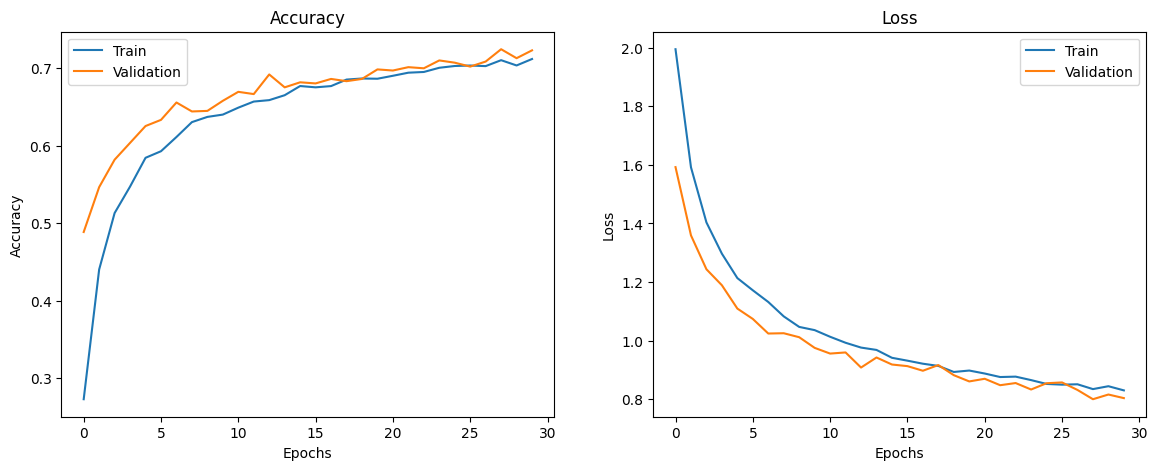

In [6]:
# ===================================
# PLOTS
# ===================================
plt.figure(figsize=(14,5))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 226ms/step

Classification Report:
              precision    recall  f1-score   support

    alluvial       0.58      0.56      0.57        77
       black       0.91      0.73      0.81       542
      cinder       0.85      0.85      0.85       178
        clay       0.62      0.64      0.63        25
    laterite       0.56      0.74      0.63       163
        peat       0.67      0.80      0.73       170
         red       0.53      0.59      0.56        78
       sandy       0.10      0.20      0.13        10
      yellow       0.63      0.68      0.65       139

    accuracy                           0.72      1382
   macro avg       0.61      0.64      0.62      1382
weighted avg       0.75      0.72      0.73      1382



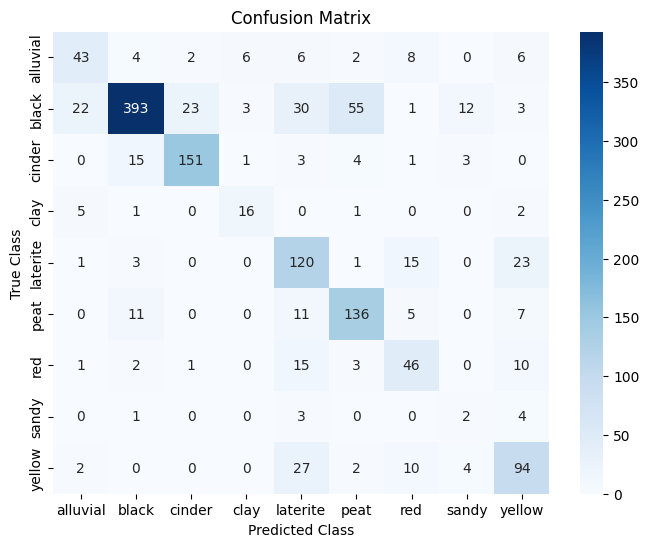

In [7]:
# ===================================
# PREDICTIONS ON VALIDATION SET
# ===================================
val.reset()
pred = model.predict(val)
y_pred = np.argmax(pred, axis=1)
y_true = val.classes

# ===================================
# CLASSIFICATION REPORT (Precision, Recall, F1)
# ===================================
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ===================================
# CONFUSION MATRIX
# ===================================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

In [5]:
model = tf.keras.models.load_model("best_inception_model.h5")


In [8]:
# Unfreeze last 50 layers
for layer in model.layers[-50:]:
    layer.trainable = True

# Keep others frozen
for layer in model.layers[:-50]:
    layer.trainable = False


In [16]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(1e-5),  # smaller LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "best_inception_finetuned.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

earlystop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)


In [18]:
history_ft = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint, earlystop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.5031 - loss: 1.4108
Epoch 1: val_accuracy improved from -inf to 0.67004, saving model to best_inception_finetuned.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 332s 768ms/step - accuracy: 0.5033 - loss: 1.4102 - val_accuracy: 0.6700 - val_loss: 0.9476
Epoch 2/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.6762 - loss: 0.9469
Epoch 2: val_accuracy improved from 0.67004 to 0.73661, saving model to best_inception_finetuned.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 299s 731ms/step - accuracy: 0.6762 - loss: 0.9468 - val_accuracy: 0.7366 - val_loss: 0.7751
Epoch 3/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.7217 - loss: 0.8015
Epoch 3: val_accuracy improved from 0.73661 to 0.76411, saving model to best_inception_finetuned.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 300s 734ms/step - accuracy: 0.7217 - loss: 0.8014 - val_accuracy: 0.7641 - val_loss: 0.6814
Epoch 4/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.7546 - loss: 0.7012
Epoch 4: val_accuracy improved from 0.76411 to 0.79161, saving model to best_inception_finetuned.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 298s 729ms/step - accuracy: 0.7546 - loss: 0.7012 - val_accuracy: 0.7916 - val_loss: 0.6058
Epoch 5/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.7793 - loss: 0.6396
Epoch 5: val_accuracy improved from 0.79161 to 0.80608, saving model to best_inception_finetuned.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 301s 735ms/step - accuracy: 0.7793 - loss: 0.6396 - val_accuracy: 0.8061 - val_loss: 0.5616
Epoch 6/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.7960 - loss: 0.5935
Epoch 6: val_accuracy improved from 0.80608 to 0.81621, saving model to best_inception_finetuned.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 300s 734ms/step - accuracy: 0.7960 - loss: 0.5935 - val_accuracy: 0.8162 - val_loss: 0.5420
Epoch 7/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accuracy: 0.8126 - loss: 0.5436
Epoch 7: val_accuracy improved from 0.81621 to 0.82634, saving model to best_inception_finetuned.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 304s 743ms/step - accuracy: 0.8126 - loss: 0.5436 - val_accuracy: 0.8263 - val_loss: 0.5083
Epoch 8/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.8322 - loss: 0.5040
Epoch 8: val_accuracy improved from 0.82634 to 0.84009, saving model to best_inception_finetuned.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 302s 737ms/step - accuracy: 0.8322 - loss: 0.5041 - val_accuracy: 0.8401 - val_loss: 0.4755
Epoch 9/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.8359 - loss: 0.4728
Epoch 9: val_accuracy did not improve from 0.84009
409/409 ━━━━━━━━━━━━━━━━━━━━ 301s 735ms/step - accuracy: 0.8359 - loss: 0.4728 - val_accuracy: 0.8394 - val_loss: 0.4689
Epoch 10/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.8409 - loss: 0.4598
Epoch 10: val_accuracy improved from 0.84009 to 0.86903, saving model to best_inception_finetuned.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 298s 727ms/step - accuracy: 0.8409 - loss: 0.4598 - val_accuracy: 0.8690 - val_loss: 0.3938
Epoch 11/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.8444 - loss: 0.4436
Epoch 11: val_accuracy improved from 0.86903 to 0.87265, saving model to best_inception_finetuned.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 300s 733ms/step - accuracy: 0.8444 - loss: 0.4436 - val_accuracy: 0.8726 - val_loss: 0.3777
Epoch 12/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.8610 - loss: 0.4163
Epoch 12: val_accuracy did not improve from 0.87265
409/409 ━━━━━━━━━━━━━━━━━━━━ 301s 737ms/step - accuracy: 0.8610 - loss: 0.4163 - val_accuracy: 0.8712 - val_loss: 0.3599
Epoch 13/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.8700 - loss: 0.3850
Epoch 13: val_accuracy did not improve from 0.87265
409/409 ━━━━━━━━━━━━━━━━━━━━ 299s 730ms/step - accuracy: 0.8700 - loss: 0.3850 - val_accuracy: 0.8719 - val_loss: 0.3633
Epoch 14/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.8762 - loss: 0.3661
Epoch 14: val_accuracy improved from 0.87265 to 0.88929, saving model to best_inception_finetuned.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 300s 733ms/step - accuracy: 0.8762 - loss: 0.3661 - val_accuracy: 0.8893 - val_loss: 0.3321
Epoch 15/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.8742 - loss: 0.3637
Epoch 15: val_accuracy did not improve from 0.88929
409/409 ━━━━━━━━━━━━━━━━━━━━ 300s 732ms/step - accuracy: 0.8742 - loss: 0.3637 - val_accuracy: 0.8893 - val_loss: 0.3314
Restoring model weights from the end of the best epoch: 15.


44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step

Classification Report:
              precision    recall  f1-score   support

    alluvial       0.80      0.71      0.75        77
       black       0.98      0.90      0.94       542
      cinder       0.97      0.97      0.97       178
        clay       0.81      0.68      0.74        25
    laterite       0.85      0.88      0.87       163
        peat       0.81      0.93      0.87       170
         red       0.65      0.82      0.72        78
       sandy       0.71      0.50      0.59        10
      yellow       0.85      0.92      0.89       139

    accuracy                           0.89      1382
   macro avg       0.83      0.81      0.81      1382
weighted avg       0.90      0.89      0.89      1382



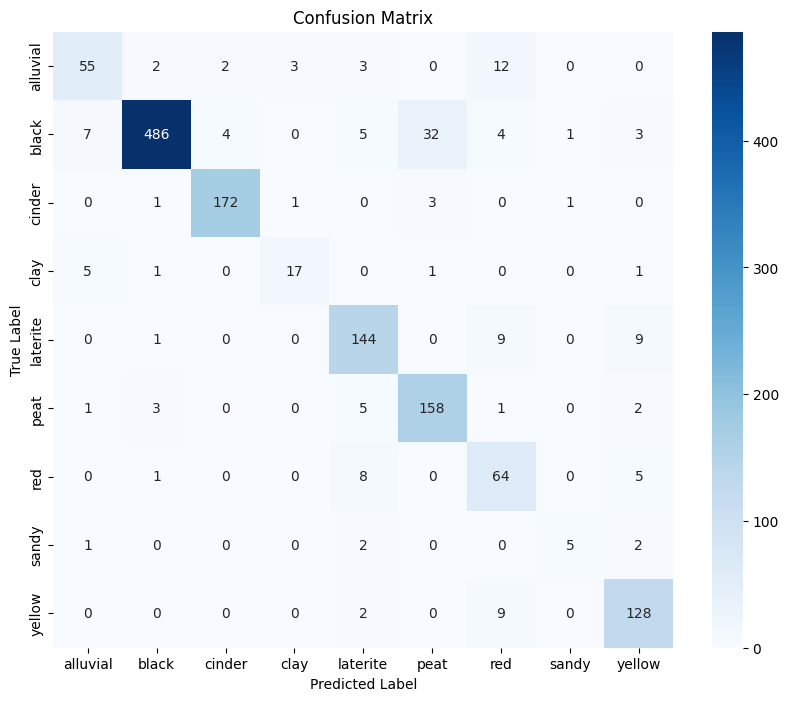

In [19]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load best fine-tuned model
model = load_model("best_inception_finetuned.h5")

# Predict on validation dataset
y_pred = model.predict(val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val.classes

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()


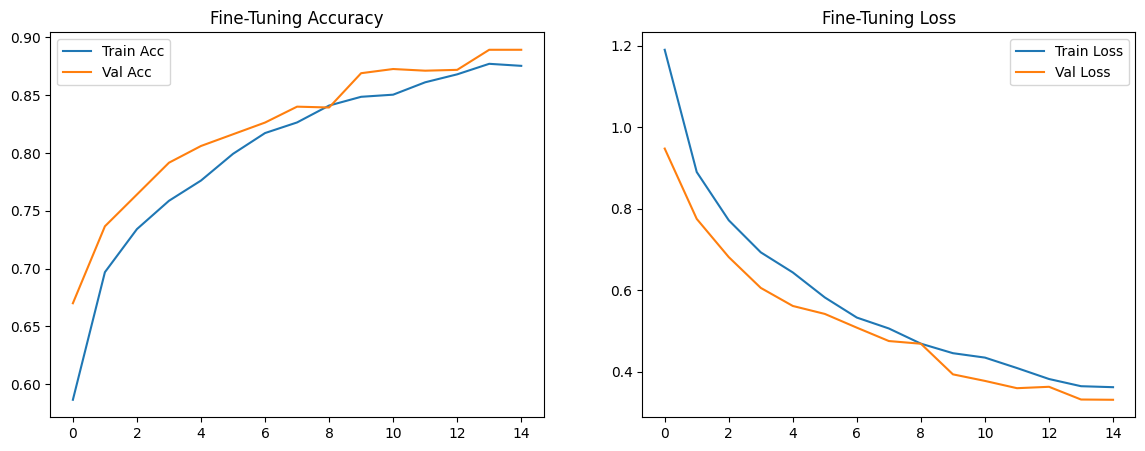

In [22]:
def plot_history(history, title):
    plt.figure(figsize=(14,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(title + " Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(title + " Loss")
    plt.legend()

    plt.show()

plot_history(history_ft, "Fine-Tuning")


In [1]:
model.save("final_soil_model.keras")


NameError: name 'model' is not defined

In [7]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/input/models/final_soil_model.keras", compile=False)


In [8]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [9]:
loss, acc = model.evaluate(val_generator)
print("Val Accuracy:", acc)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1764155828.325853     112 service.cc:148] XLA service 0x7d60c8002970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764155828.328211     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764155828.328234     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764155829.325770     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/44 ━━━━━━━━━━━━━━━━━━━━ 10:23 14s/step - accuracy: 0.7188 - loss: 1.2759

I0000 00:00:1764155839.236333     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 410ms/step - accuracy: 0.8625 - loss: 0.4296
Val Accuracy: 0.8892908692359924


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (299, 299)
BATCH = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    rotation_range=25,
    zoom_range=0.25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=10,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3]
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

train = train_datagen.flow_from_directory(
    "/kaggle/input/soilss/Soil Type.v2-efficientb3.folder/train",
    target_size=IMAGE_SIZE,
    batch_size=BATCH,
    class_mode='categorical'
)

val = val_datagen.flow_from_directory(
    "/kaggle/input/soilss/Soil Type.v2-efficientb3.folder/valid",
    target_size=IMAGE_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=False
)


Found 13073 images belonging to 9 classes.
Found 1382 images belonging to 9 classes.


In [13]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/input/models/final_soil_model.keras", compile=False)

In [15]:
for layer in model.layers[:-150]:
    layer.trainable = False

for layer in model.layers[-150:]:
    layer.trainable = True


In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    "best_90plus_model.h5",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

earlystop = EarlyStopping(
    monitor="val_accuracy",
    patience=4,
    mode="max",
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=5e-7,
    verbose=1
)


In [18]:
history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=8,
    callbacks=[checkpoint, earlystop, reduce_lr]
)


Epoch 1/8
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7703 - loss: 0.6464
Epoch 1: val_accuracy improved from -inf to 0.77713, saving model to best_90plus_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 476s 1s/step - accuracy: 0.7703 - loss: 0.6463 - val_accuracy: 0.7771 - val_loss: 0.6085 - learning_rate: 1.0000e-05
Epoch 2/8
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.8439 - loss: 0.4520
Epoch 2: val_accuracy improved from 0.77713 to 0.84081, saving model to best_90plus_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 338s 826ms/step - accuracy: 0.8439 - loss: 0.4519 - val_accuracy: 0.8408 - val_loss: 0.4707 - learning_rate: 1.0000e-05
Epoch 3/8
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.8734 - loss: 0.3625
Epoch 3: val_accuracy improved from 0.84081 to 0.85239, saving model to best_90plus_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 339s 829ms/step - accuracy: 0.8734 - loss: 0.3625 - val_accuracy: 0.8524 - val_loss: 0.4157 - learning_rate: 1.0000e-05
Epoch 4/8
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.8892 - loss: 0.3257
Epoch 4: val_accuracy improved from 0.85239 to 0.86831, saving model to best_90plus_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 336s 821ms/step - accuracy: 0.8892 - loss: 0.3257 - val_accuracy: 0.8683 - val_loss: 0.3904 - learning_rate: 1.0000e-05
Epoch 5/8
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.8975 - loss: 0.2894
Epoch 5: val_accuracy improved from 0.86831 to 0.87699, saving model to best_90plus_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 340s 831ms/step - accuracy: 0.8975 - loss: 0.2894 - val_accuracy: 0.8770 - val_loss: 0.3574 - learning_rate: 1.0000e-05
Epoch 6/8
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.9153 - loss: 0.2477
Epoch 6: val_accuracy improved from 0.87699 to 0.91172, saving model to best_90plus_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 343s 838ms/step - accuracy: 0.9153 - loss: 0.2477 - val_accuracy: 0.9117 - val_loss: 0.2743 - learning_rate: 1.0000e-05
Epoch 7/8
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.9201 - loss: 0.2347
Epoch 7: val_accuracy did not improve from 0.91172
409/409 ━━━━━━━━━━━━━━━━━━━━ 336s 821ms/step - accuracy: 0.9201 - loss: 0.2347 - val_accuracy: 0.9096 - val_loss: 0.2652 - learning_rate: 1.0000e-05
Epoch 8/8
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.9275 - loss: 0.2082
Epoch 8: val_accuracy improved from 0.91172 to 0.92258, saving model to best_90plus_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 337s 825ms/step - accuracy: 0.9275 - loss: 0.2082 - val_accuracy: 0.9226 - val_loss: 0.2453 - learning_rate: 1.0000e-05


In [24]:
import os
print(os.getcwd())       # Shows the current working directory
print(os.listdir())      # Lists files in that directory, you should see 'best_90plus_model.h5'


/kaggle/working
['.virtual_documents', 'best_90plus_model.h5']


In [25]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model("/kaggle/working/best_90plus_model.h5")

# Evaluate on validation data
loss, acc = model.evaluate(val)
print("Validation Accuracy:", acc)

# Make predictions
preds = model.predict(val)
pred_classes = preds.argmax(axis=1)


44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 218ms/step - accuracy: 0.9008 - loss: 0.3346
Validation Accuracy: 0.9225759506225586
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 239ms/step


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step
Classification Report:
               precision    recall  f1-score   support

    alluvial       0.89      0.77      0.83        77
       black       0.99      0.93      0.96       542
      cinder       0.98      0.97      0.98       178
        clay       0.86      0.72      0.78        25
    laterite       0.89      0.91      0.90       163
        peat       0.88      0.96      0.92       170
         red       0.67      0.91      0.77        78
       sandy       0.86      0.60      0.71        10
      yellow       0.93      0.95      0.94       139

    accuracy                           0.92      1382
   macro avg       0.88      0.86      0.86      1382
weighted avg       0.93      0.92      0.92      1382



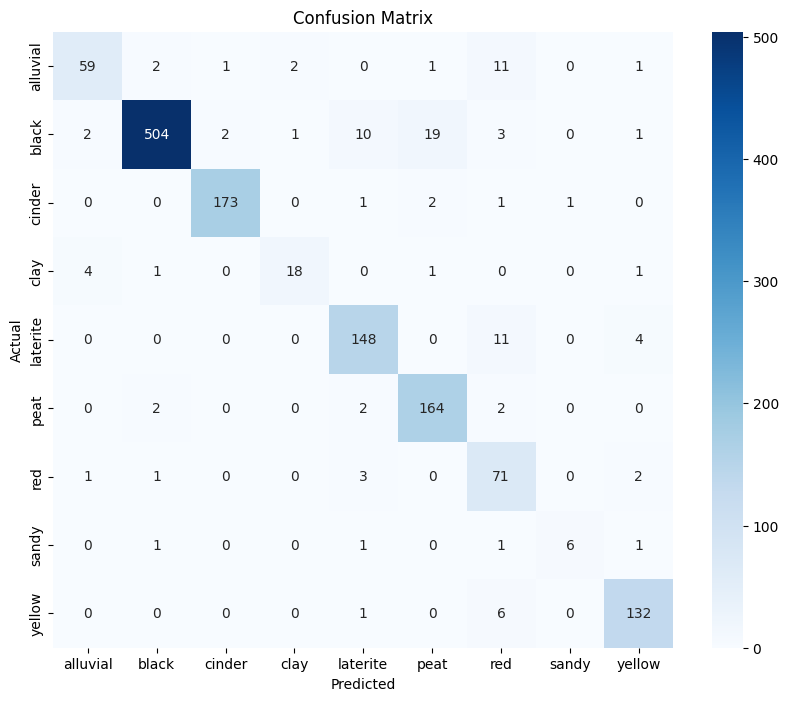

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict probabilities
preds = model.predict(val)
# Convert probabilities to class indices
pred_classes = np.argmax(preds, axis=1)
# True labels
true_classes = val.classes
# Class names
class_names = list(val.class_indices.keys())

# Classification report
report = classification_report(true_classes, pred_classes, target_names=class_names)
print("Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Found 1382 images belonging to 9 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 230ms/step
Classification Report:
               precision    recall  f1-score   support

    alluvial       0.89      0.77      0.83        77
       black       0.99      0.93      0.96       542
      cinder       0.98      0.97      0.98       178
        clay       0.86      0.72      0.78        25
    laterite       0.89      0.91      0.90       163
        peat       0.88      0.96      0.92       170
         red       0.67      0.91      0.77        78
       sandy       0.86      0.60      0.71        10
      yellow       0.93      0.95      0.94       139

    accuracy                           0.92      1382
   macro avg       0.88      0.86      0.86      1382
weighted avg       0.93      0.92      0.92      1382



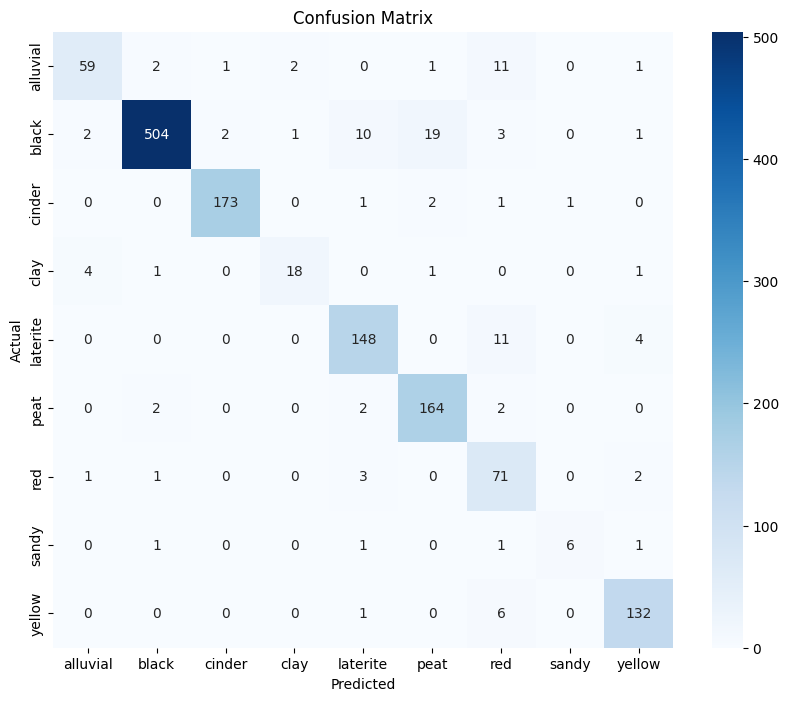

44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.9008 - loss: 0.3346
Validation Accuracy: 0.9226


In [27]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# PARAMETERS
# ---------------------------
IMAGE_SIZE = (299, 299)
BATCH = 32
MODEL_PATH = "/kaggle/working/best_90plus_model.h5"
TEST_DIR = "/kaggle/input/soilss/Soil Type.v2-efficientb3.folder/valid"  # or your test folder

# ---------------------------
# LOAD MODEL
# ---------------------------
model = tf.keras.models.load_model(MODEL_PATH)

# ---------------------------
# PREPARE TEST DATA
# ---------------------------
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=False
)

# ---------------------------
# PREDICTIONS
# ---------------------------
preds = model.predict(test_generator)
pred_classes = np.argmax(preds, axis=1)
true_classes = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# ---------------------------
# CLASSIFICATION REPORT
# ---------------------------
report = classification_report(true_classes, pred_classes, target_names=class_names)
print("Classification Report:\n", report)

# ---------------------------
# CONFUSION MATRIX
# ---------------------------
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ---------------------------
# VALIDATION ACCURACY
# ---------------------------
loss, acc = model.evaluate(test_generator)
print(f"Validation Accuracy: {acc:.4f}")


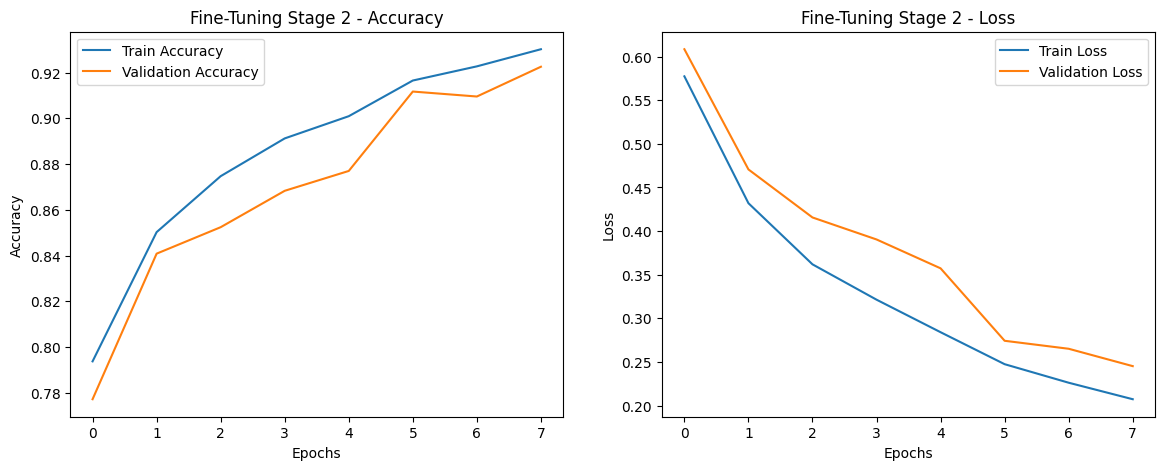

In [28]:
import matplotlib.pyplot as plt

def plot_history(history, title="Model Performance"):
    plt.figure(figsize=(14,5))
    
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title + " - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title + " - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.show()

# Call the function with your training history
plot_history(history_stage2, "Fine-Tuning Stage 2")


In [47]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = tf.keras.models.load_model("/kaggle/working/best_90plus_model.h5")

# Path to your test image
img_path = "/kaggle/input/soilss/Soil Type.v2-efficientb3.folder/valid/yellow/5_jpg.rf.b7edea67134a7e54880947bc8e7e3bb9.jpg"  # Replace with your image path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(299, 299))  # Use same size as training
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)  # Preprocess like training

# Make prediction
preds = model.predict(img_array)
pred_class_index = np.argmax(preds, axis=1)[0]
pred_class_name = class_names[pred_class_index]
confidence = preds[0][pred_class_index]

print(f"Predicted class: {pred_class_name}")
print(f"Confidence: {confidence:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: yellow
Confidence: 0.8478


In [49]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load model once (do this when your app starts)
model = tf.keras.models.load_model("/kaggle/working/best_90plus_model.h5")

def predict_soil_type(img_path):
    """
    Predicts soil type from a given image path.
    Returns the class name and confidence.
    """
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
    
    preds = model.predict(img_array)
    class_index = np.argmax(preds, axis=1)[0]
    class_name = class_names[class_index]
    confidence = preds[0][class_index]
    
    return class_name, confidence


In [50]:
!pip install gradio --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 12.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.3 MB/s eta 0:00:0000:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [52]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load your model
model = load_model("/kaggle/working/best_90plus_model.h5")

# Compile it so metrics work
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Now you can evaluate
loss, acc = model.evaluate(val)
print("Val Accuracy:", acc)


44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 217ms/step - accuracy: 0.9008 - loss: 0.3346
Val Accuracy: 0.9225759506225586


In [51]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import gradio as gr

# Load your saved model
model = tf.keras.models.load_model("/kaggle/working/best_90plus_model.h5")

# Your class names
class_names = ['alluvial','black','cinder','clay','laterite','peat','red','sandy','yellow']

def predict_soil(img):
    # Convert image to model input
    img = img.resize((299, 299))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)

    preds = model.predict(img_array)
    class_index = np.argmax(preds, axis=1)[0]
    class_name = class_names[class_index]
    confidence = preds[0][class_index]

    return {class_names[i]: float(preds[0][i]) for i in range(len(class_names))}, f"Predicted: {class_name} ({confidence*100:.2f}%)"


In [53]:
# Image input, softmax output
iface = gr.Interface(
    fn=predict_soil,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Label(num_top_classes=3), gr.Textbox()],
    title="Soil Type Classifier",
    description="Upload a soil image and the model will predict its type with confidence."
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://07ccfb1ee125169006.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [62]:
import gradio as gr
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input

# ----------------------------
# Load your trained model
# ----------------------------
model_path = "/kaggle/working/best_90plus_model.h5"
model = load_model(model_path)
class_names = ['alluvial','black','cinder','clay','laterite','peat','red','sandy','yellow']

# ----------------------------
# OOD threshold
# ----------------------------
CONFIDENCE_THRESHOLD = 0.7  # you can tweak this

# ----------------------------
# Prediction function
# ----------------------------
def predict_soil(img):
    # Resize and preprocess
    img = img.resize((299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Predict
    preds = model.predict(x)
    max_prob = np.max(preds)
    pred_class = np.argmax(preds)
    
    if max_prob < CONFIDENCE_THRESHOLD:
        return "Unknown", float(max_prob)
    else:
        return class_names[pred_class], float(max_prob)

# ----------------------------
# Gradio UI
# ----------------------------
iface = gr.Interface(
    fn=predict_soil,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Label(num_top_classes=1), gr.Number(label="Confidence")],
    title="Soil Type Classifier with OOD Detection",
    description="Upload an image of soil. If the image is not soil, it will return 'Unknown'."
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7866
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://ce446395145196caca.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [63]:
!pip install fastapi uvicorn[standard] nest-asyncio pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.6/456.6 kB 10.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 74.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.1/456.1 kB 30.7 MB/s eta 0:00:00


In [60]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

# ----------------------------
# Paths and parameters
# ----------------------------
model_path = "/kaggle/working/best_90plus_model.h5"
train_dir = "/kaggle/input/soilss/Soil Type.v2-efficientb3.folder/train"
centroid_file = "/kaggle/working/class_centroids.npy"
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32

# ----------------------------
# Load model and create feature extractor
# ----------------------------
base_model = load_model(model_path)
feature_layer = base_model.layers[-2].output  # adjust if last Dense is different
feature_extractor = Model(inputs=base_model.input, outputs=feature_layer)

# ----------------------------
# Class names
# ----------------------------
class_names = ['alluvial','black','cinder','clay','laterite','peat','red','sandy','yellow']

# ----------------------------
# Compute or load centroids
# ----------------------------
if os.path.exists(centroid_file):
    print("Loading saved centroids...")
    class_centroids = np.load(centroid_file, allow_pickle=True).item()
else:
    print("Computing class centroids (batched)...")
    
    # Data generator for the whole training set
    datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
    generator = datagen.flow_from_directory(
        train_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    # Extract features for all images
    features = feature_extractor.predict(generator, verbose=1)
    labels = generator.classes  # numeric labels
    class_indices = generator.class_indices  # mapping class_name -> index
    index_to_class = {v: k for k, v in class_indices.items()}
    
    # Compute centroids
    class_centroids = {}
    for i, cls in enumerate(class_names):
        cls_features = features[labels == i]
        centroid = np.mean(cls_features, axis=0)
        class_centroids[cls] = centroid
    
    # Save centroids for future use
    np.save(centroid_file, class_centroids)
    print("Centroids computed and saved!")


Computing class centroids (batched)...
Found 13073 images belonging to 9 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


409/409 ━━━━━━━━━━━━━━━━━━━━ 63s 143ms/step
Centroids computed and saved!


In [61]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
import numpy as np
import gradio as gr
from PIL import Image

# ----------------------------
# Paths
# ----------------------------
model_path = "/kaggle/working/best_90plus_model.h5"
centroid_file = "/kaggle/working/class_centroids.npy"

# ----------------------------
# Load model
# ----------------------------
base_model = load_model(model_path)
feature_layer = base_model.layers[-2].output  # adjust if last Dense layer is different
feature_extractor = Model(inputs=base_model.input, outputs=feature_layer)

# ----------------------------
# Load centroids
# ----------------------------
class_centroids = np.load(centroid_file, allow_pickle=True).item()
class_names = list(class_centroids.keys())

# ----------------------------
# Prediction function with OOD check
# ----------------------------
def predict_soil(img: Image.Image):
    # Preprocess image
    IMAGE_SIZE = (299, 299)
    img_resized = img.resize(IMAGE_SIZE)
    x = image.img_to_array(img_resized)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.inception_v3.preprocess_input(x)
    
    # Softmax prediction
    preds = base_model.predict(x, verbose=0)
    max_prob = np.max(preds)
    pred_class = class_names[np.argmax(preds)]
    
    # Feature embedding
    feat = feature_extractor.predict(x, verbose=0)[0]
    
    # Compute distances to class centroids
    distances = [np.linalg.norm(feat - class_centroids[cls]) for cls in class_names]
    min_dist = np.min(distances)
    
    # Thresholds for OOD
    SOFTMAX_THRESH = 0.5       # softmax probability threshold
    DIST_THRESH = 1000.0       # adjust if needed
    
    if max_prob < SOFTMAX_THRESH or min_dist > DIST_THRESH:
        return "Unknown"
    else:
        return pred_class

# ----------------------------
# Launch Gradio UI
# ----------------------------
iface = gr.Interface(
    fn=predict_soil,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Soil Type Classifier with OOD Detection",
    description="Upload a soil image. If the image is not soil or confidence is low, it will return 'Unknown'."
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7865
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://7a82eb16786e3c745a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
